                              Project - Predicting Customer Lifetime Value (CLV) & Segmenting Customers using Clustering  
                                                    Submitted By -Anmay Kapoor  
                               
Dataset:[Online Retail II (UK-based giftware e-commerce)](https://www.kaggle.com/datasets/lakshmi25npathi/online-retail-dataset)   

- Objective:
1. Predict the potential future value of a customer (CLV)
2. Segment customers using clustering for business strategy


                                                        Step 1: -Load & Inspect Dataset


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# %%
df1 = pd.read_excel('/Users/sakshamkapoor/Downloads/online_retail_II.xlsx', sheet_name='Year 2009-2010')
df2 = pd.read_excel('/Users/sakshamkapoor/Downloads/online_retail_II.xlsx', sheet_name='Year 2010-2011')
df = pd.concat([df1, df2], ignore_index=True)
print(" Data Loaded | Shape:", df.shape)

 Data Loaded | Shape: (1067371, 8)


                                                           Step 2: Data Cleaning

In [2]:
df.dropna(subset=['Customer ID'], inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['Price']
print(" Cleaned Data | Shape:", df.shape)

 Cleaned Data | Shape: (805549, 9)


                                                       Step 3: EDA - Distribution Plots

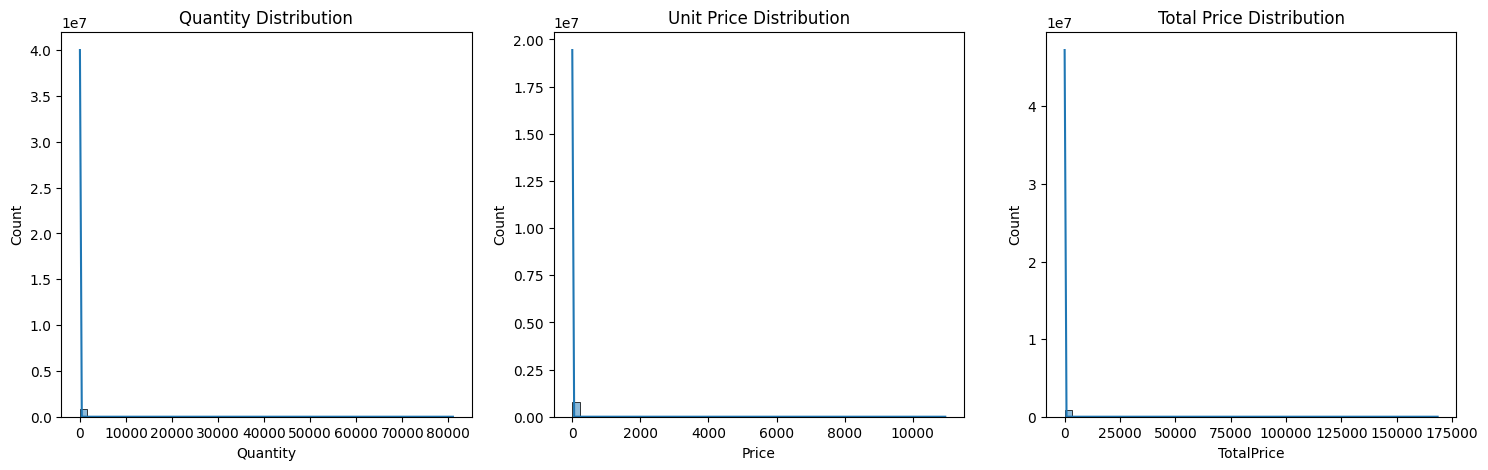

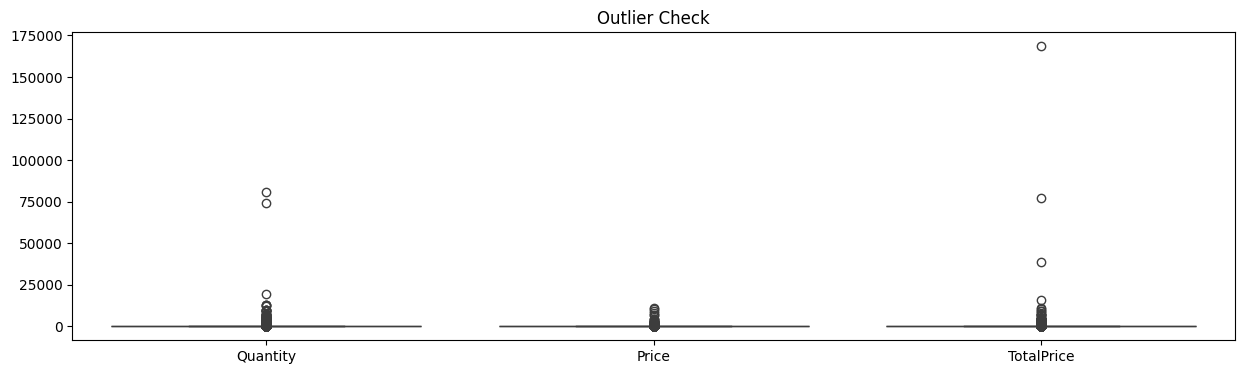

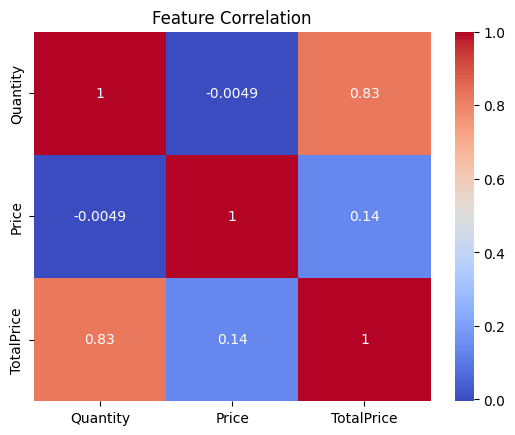

In [3]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.histplot(df['Quantity'], bins=50, kde=True)
plt.title("Quantity Distribution")

plt.subplot(1,3,2)
sns.histplot(df['Price'], bins=50, kde=True)
plt.title("Unit Price Distribution")

plt.subplot(1,3,3)
sns.histplot(df['TotalPrice'], bins=50, kde=True)
plt.title("Total Price Distribution")
plt.show()

# %%
#  Boxplot to check outliers
plt.figure(figsize=(15,4))
sns.boxplot(data=df[['Quantity', 'Price', 'TotalPrice']])
plt.title("Outlier Check")
plt.show()

# %%
#  Correlation Heatmap
corr = df[['Quantity', 'Price', 'TotalPrice']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

                                                          Step 4: Feature Engineering- RFM Table

 RFM Table Created | Shape: (5878, 6)


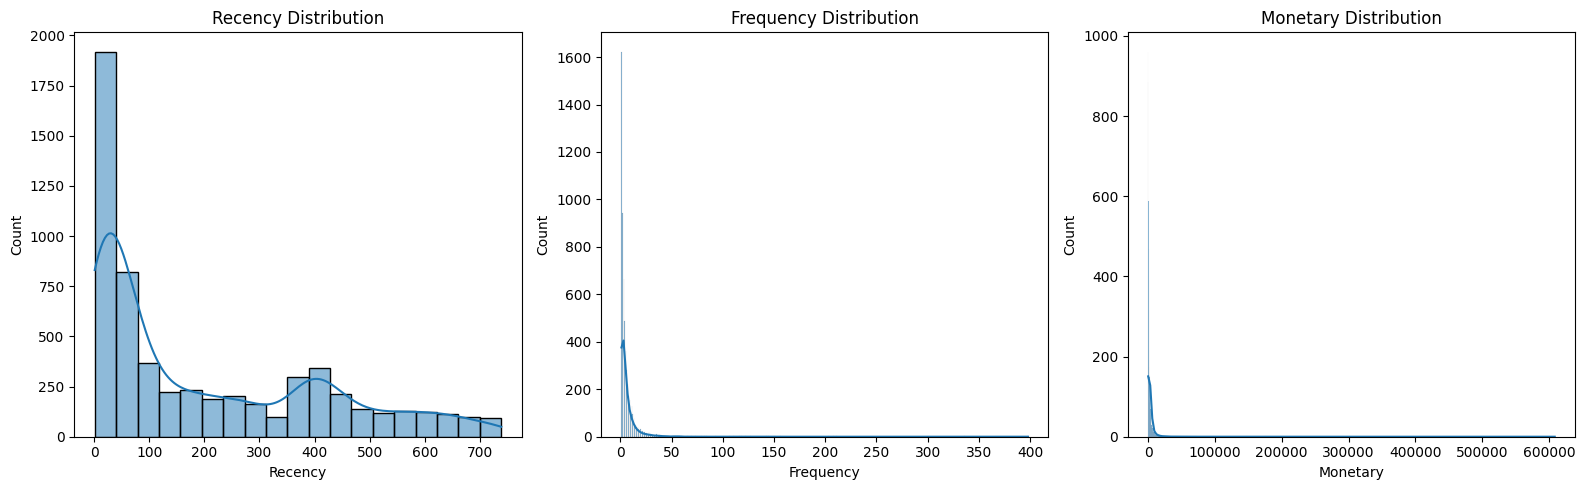

In [4]:
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique', 
    'TotalPrice': 'sum',
    'StockCode': 'nunique',
    'Description': lambda x: x.str.contains('discount|sale', case=False).mean()
}).rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalPrice': 'Monetary',
    'StockCode': 'ProductDiversity',
    'Description': 'DiscountSensitivity'
})
rfm['AvgOrderValue'] = rfm['Monetary']/rfm['Frequency']
rfm = rfm[rfm['Monetary'] > 0]
print(" RFM Table Created | Shape:", rfm.shape)

# %%
# RFM distributions
plt.figure(figsize=(16,5))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1,3,i+1)
    sns.histplot(rfm[col], kde=True)
    plt.title(f"{col} Distribution")
plt.tight_layout()
plt.show()

                                                 Step 5: Model Training - CLV Prediction (Regression)

Note: - Linear and Ridge regression were initially tested but excluded due to very poor R² scores (even negative), showing they couldn’t capture the complexity of the CLV data.

- Additionally, K-Nearest Neighbors (KNN) was tried but gave weak performance (low R² and high RMSE), likely due to its sensitivity to irrelevant features and lack of robustness in high-dimensional data.

- Tree-based models like Random Forest, Decision Tree, and Gradient Boosting captured non-linear relationships and feature interactions effectively, with Gradient Boosting showing the best overall performanc

In [5]:

  
# Prepare data 
X = rfm[['Recency', 'Frequency', 'ProductDiversity', 'AvgOrderValue']]
y = rfm['Monetary']  # Keep original scale for interpretability

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  
# Train only relevant models
rf = RandomForestRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state=42)

rf.fit(X_train, y_train)
gbr.fit(X_train, y_train)
knn.fit(X_train, y_train)
dt.fit(X_train, y_train)
# Evaluate
def evaluate(name, model):
    pred = model.predict(X_test)
    r2 = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f"\n📌 {name} Performance:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: ₹{rmse:,.2f}")

evaluate("Random Forest", rf)
evaluate("Gradient Boosting", gbr)
evaluate("K-Nearest Neighbors", knn)
evaluate("Decision Tree", dt)
  
  
  


📌 Random Forest Performance:
R² Score: 0.8888
RMSE: ₹6,390.55

📌 Gradient Boosting Performance:
R² Score: 0.9703
RMSE: ₹3,300.89

📌 K-Nearest Neighbors Performance:
R² Score: 0.2109
RMSE: ₹17,025.66

📌 Decision Tree Performance:
R² Score: 0.9410
RMSE: ₹4,656.12


                                                     Step 6: Hyperparameter Tuning (Random Forest)

In [6]:
# Hyperparameter Tuning (Only RF)

params = {
    'n_estimators': [100, 150],
    'max_depth': [5, 7, None],  # None = unlimited depth
    'min_samples_split': [2, 5]  # Less restrictive
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=params,
    cv=3,
    scoring='r2'
)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
print("\n Best Random Forest Params:", grid.best_params_)
evaluate("Tuned Random Forest", best_rf)


 Best Random Forest Params: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 100}

📌 Tuned Random Forest Performance:
R² Score: 0.8922
RMSE: ₹6,293.35


                                                  Step 7: Clustering - Customer Segmentation (KMeans)

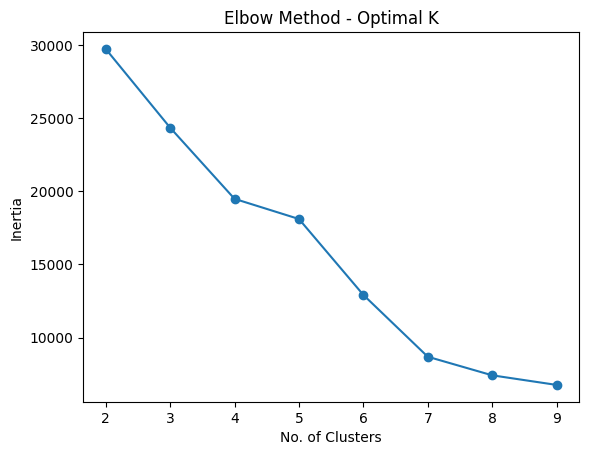

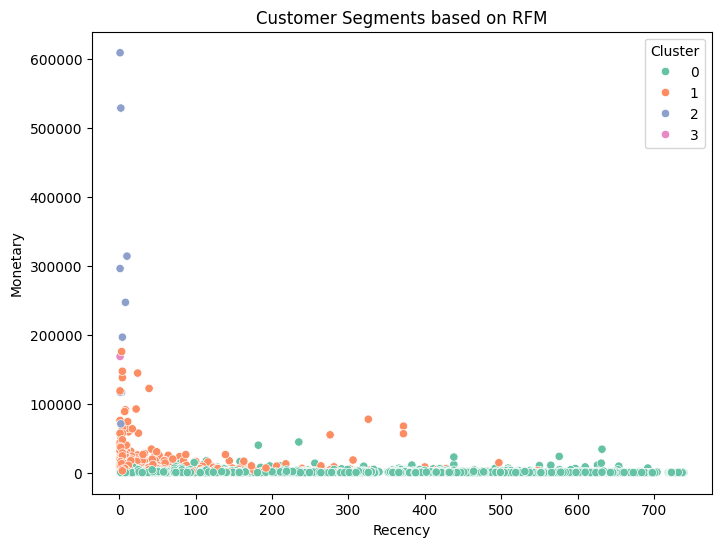

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Dropping 'Cluster' column if it exists to avoid issues, then scale
rfm_scaled = scaler.fit_transform(rfm.drop('Cluster', axis=1, errors='ignore'))
k_range = range(2, 10)
inertias = []

# %%
for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    inertias.append(model.inertia_)

# Elbow Plot
plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Method - Optimal K")
plt.xlabel("No. of Clusters")
plt.ylabel("Inertia")
plt.show()

# Final KMeans model 
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Cluster Visualization
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2')
plt.title("Customer Segments based on RFM")
plt.show()

                                                       Step 8: Final Summary & Business Insights:

Objective Recap
Our goal was to predict Customer Lifetime Value (CLV) using historical purchase behavior, and to identify distinct customer segments for better marketing and retention strategies.

---

 Model Performance Recap:
- Gradient Boosting Regressor delivered the best results:
  - R² Score: 0.9703  
  - RMSE: ₹3,300.89  
- Random Forest also performed well:
  - Tuned R²: 0.8922  
  - RMSE:₹6,293.35  
- Decision Tree Regressor also performed well:
  - R² Score: 0.9410
  - RMSE: ₹4,656.12
- K-Nearest Neighbors (KNN) performed poorly:
  - R² Score: 0.2109
  - RMSE: ₹17,025.66
 
- Note: Linear and Ridge Regression were initially tested but excluded due to negative R² scores, showing they failed to capture the complexity in the data. Similarly, KNN struggled due to high sensitivity to irrelevant features and lack of robustness in this context.

- Tree-based models handled non-linear patterns well, with Gradient Boosting emerging as the most robust..

---

 Key Features Used:
- Recency: How recently the customer purchased  
- Frequency: How often they buy  
- Monetary: How much they spend  
- Product Diversity: Variety of items they purchase  
- Avg Order Value & Weekend Shopper indicators

---

 Segmentation Insights (KMeans):
- Customers were grouped into 4 clusters using scaled RFM features.
- Clusters show clear separation between high-value and low-value segments.
- Helps in building targeted campaigns (e.g., VIP customers vs one-time buyers).

---

 Final Takeaways:
- The model is highly effective in predicting CLV, especially with Gradient Boosting.
- Enhanced RFM features improved model performance and customer understanding.
- Segmentation helps prioritize marketing spend, improve retention, and identify upsell opportunities.

---


